# Noise reduction on FBP

We will here try to see how we can manage to reduce noise on a noisy FBP image. Such an image can be obtain because of irregularities on the sinogram. We simulate them by adding gaussian noise to our phantom from which we compute the sinogram.

### Effect of the narrow factor on the noise reduction

The narrow factor allows to cut in a little sharper the high spatial frequencies of the image.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../design/')
from image import Image
from phantom import Phantom
from sinogram import Sinogram
from fbp import FBP

size = 256
phantom = Phantom('brain3.jpg', size=-1, blur=-1, noise=1)
sinogram = Sinogram(phantom)
thetas = np.arange(180, step=1)
sinogram.compute(thetas)

fbp = FBP.compute(sinogram, thetas, size)

fig, axes = plt.subplots(3, 2, figsize=(11, 15))
axes = axes.flatten()

Image.plot(phantom.img,
           axes[0],
           title='Phantom')
Image.plot(fbp,
           axes[1],
           title='FBP')

n_fs = [0.000, 0.003, 0.004, 0.01]

for i in range(len(n_fs)):
    processed_fbp = np.copy(fbp)
    processed_fbp = Image.reduce_noise(processed_fbp, n_fs[i])
    Image.plot(processed_fbp,
               axes[i + 2],
               title='Noise reduction (n_f = %.3g)' % n_fs[i])

Let us see how its variation impacts on noise reduction by comparing the error RMS of the processed/not processed FBP image, the processed images having a variating narrow factor used for noise reduction.

In [2]:
size = 256
phantom = Phantom('brain3.jpg', size=-1, blur=-1, noise=1)
sinogram = Sinogram(phantom)
thetas = np.arange(180, step=1)
sinogram.compute(thetas)

true_phantom = Phantom('brain3.jpg', size=-1, blur=-1, noise=-1)

fbp = FBP.compute(sinogram, thetas, size)
noisy_error = fbp - phantom.img
noisy_rms = np.sqrt(np.mean(noisy_error**2))

n_fs = np.arange(100) * 0.0001
rms = []
for i in range(len(n_fs)):
    processed_fbp = np.copy(fbp)
    processed_fbp = Image.reduce_noise(processed_fbp, n_fs[i])
    error = processed_fbp - true_phantom.img
    rms.append(np.sqrt(np.mean(error**2)) / noisy_rms)

fig = plt.figure()
plt.plot(n_fs, rms)
plt.title('Ratio of error RMS to true/noisy phantom according to narrow factor')
plt.xlabel('Narrow factor')
plt.ylabel('Ratio')
plt.show()

### Effect of noise reduction on error RMS according to noise amplitude

From the precedent figure we see that the narrow_factor in our case only induces a higher error when becoming too high. Better let it at zero then.

In [5]:
size = 256
max_noise_amp = 5
noise_amps = [0, 1, 3, 5]

fig, axes = plt.subplots(4, 2, figsize=(10, 28))
axes = axes.flatten()

for i in range(len(noise_amps)):
    phantom = Phantom('brain3.jpg', size=-1, blur=-1, noise=noise_amps[i])
    sinogram = Sinogram(phantom)
    thetas = np.arange(180, step=1)
    sinogram.compute(thetas)
    Image.plot(sinogram.sng,
               axes[2*i],
               title='Sinogram (noise amplitude = %.3g)' % noise_amps[i], 
               x_label='Projection angle (deg)', 
               y_label='Projection position (pixels)', 
               extent=(0, 180, 0, sinogram.sng.shape[0]), 
               aspect='auto')

    fbp = FBP.compute(sinogram, thetas, size)
    fbp = Image.reduce_noise(fbp)
    Image.plot(fbp,
               axes[2*i + 1],
               title='FBP')

Using a narrow factor equal to 0, let us see how the error RMS variates with the amplitude of the gaussian noise applied to the image. We will for that compare the error RMS of the processed/not processed FBP image.

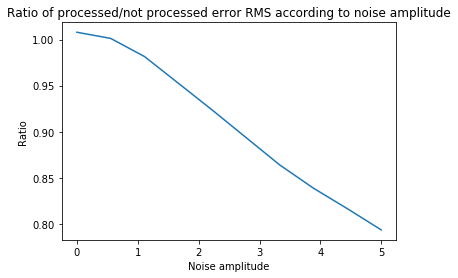

In [6]:
size = 256
true_phantom = Phantom('brain3.jpg', size=-1, blur=-1, noise=-1)

thetas = np.arange(180, step=1)

max_noise_amp = 5
count = 10
noise_amps = np.linspace(0, max_noise_amp, count)
rms = []
for i in range(count):
    phantom = Phantom('brain3.jpg', size=-1, blur=-1, noise=noise_amps[i])
    sinogram = Sinogram(phantom)
    sinogram.compute(thetas)
    fbp = FBP.compute(sinogram, thetas, size)
    error = fbp - true_phantom.img
    
    processed_fbp = np.copy(fbp)
    processed_fbp = Image.reduce_noise(processed_fbp)
    processed_error = processed_fbp - true_phantom.img
    
    rms.append(np.sqrt(np.mean(processed_error**2)) / np.sqrt(np.mean(error**2)))

fig = plt.figure()
plt.plot(noise_amps, rms)
plt.title('Ratio of processed/not processed error RMS according to noise amplitude')
plt.xlabel('Noise amplitude')
plt.ylabel('Ratio')
plt.show()

We see as expected that the noise reduction notably reduces the error RMS.